In [97]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from quantile_forest import RandomForestQuantileRegressor
from sklearn.metrics import mean_pinball_loss


# load data
training_data = pd.read_csv('data/Training_Data_averaged.csv', index_col=0)
testing_data = pd.read_csv('data/Testing_Data_averaged.csv', index_col=0)

#for offshore use north german data
training_data_north = pd.read_csv('data/Training_Data_North.csv', index_col=0)
testing_data_north = pd.read_csv('data/Testing_Data_North.csv', index_col=0)

print(training_data.head())

                          day      hour       msl       tcc       t2m  \
time                                                                    
2019-01-01 00:00:00 -1.727278 -1.661293  1.536836  1.409440 -0.660146   
2019-01-01 01:00:00 -1.727278 -1.516833  1.486795  1.377614 -0.646824   
2019-01-01 02:00:00 -1.727278 -1.372373  1.424867  1.410695 -0.661513   
2019-01-01 03:00:00 -1.727278 -1.227912  1.335549  1.464863 -0.670784   
2019-01-01 04:00:00 -1.727278 -1.083452  1.224283  1.475456 -0.676032   

                         ssr      sund      ws10     ws100  \
time                                                         
2019-01-01 00:00:00 -0.85915 -0.990967  0.825597  0.846255   
2019-01-01 01:00:00 -0.85915 -0.990967  0.980525  0.976528   
2019-01-01 02:00:00 -0.85915 -0.990967  1.147214  1.134154   
2019-01-01 03:00:00 -0.85915 -0.990967  1.353153  1.337304   
2019-01-01 04:00:00 -0.85915 -0.990967  1.551084  1.523818   

                     max Wind Offshore [MW]  max Wind

In [98]:
# predict one hour in the future
#take training data and shift targets by one hour
training_data_one_hr = training_data.copy()

training_data_one_hr['Wind Offshore [MW] '] = training_data['Wind Offshore [MW] '].shift(-1)
training_data_one_hr['Wind Onshore [MW]'] = training_data['Wind Onshore [MW]'].shift(-1)
training_data_one_hr['Photovoltaic [MW]'] = training_data['Photovoltaic [MW]'].shift(-1)

# drop last row
training_data_one_hr = training_data_one_hr.dropna()

training_data_2019 = training_data_one_hr[training_data_one_hr['year'] == 2019]
training_data_2020 = training_data_one_hr[training_data_one_hr['year'] == 2020]
training_data_2021 = training_data_one_hr[training_data_one_hr['year'] == 2021]




combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without featur

{'offshore': 284.8045017506976, 'onshore': 514.674033888643, 'photovoltaic': 158.22229504655488}


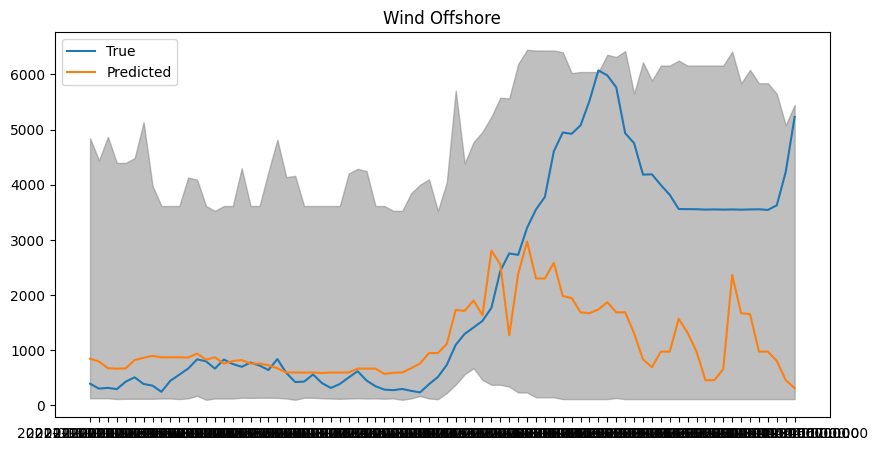

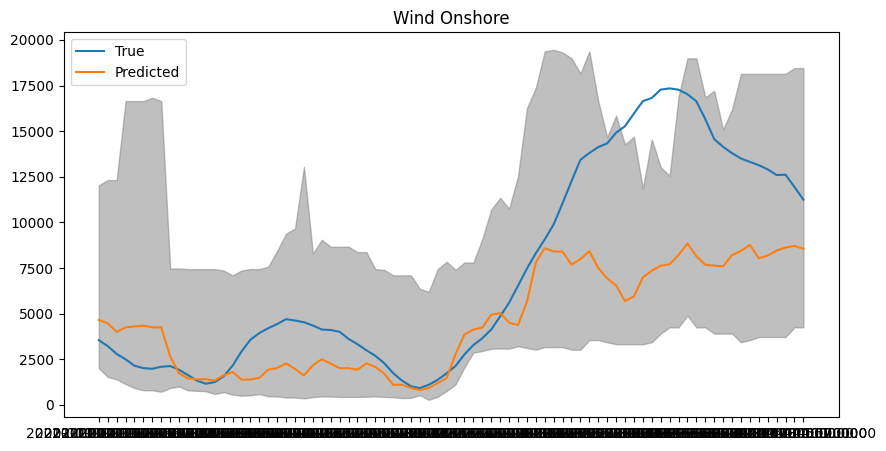

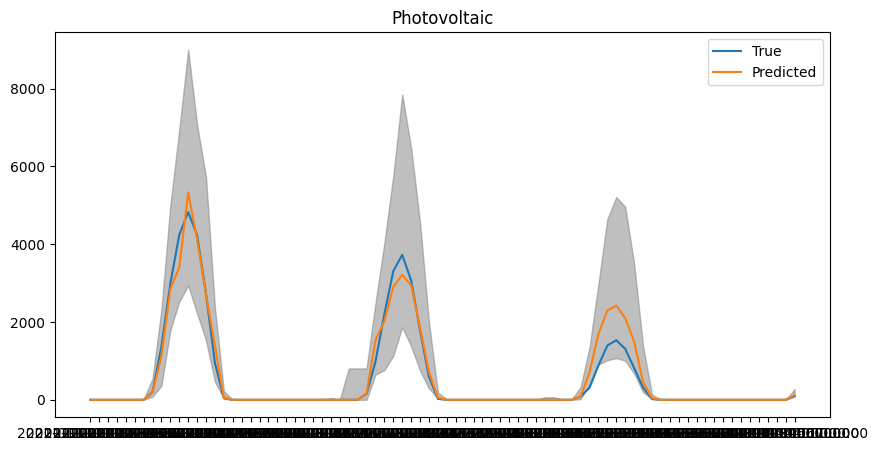

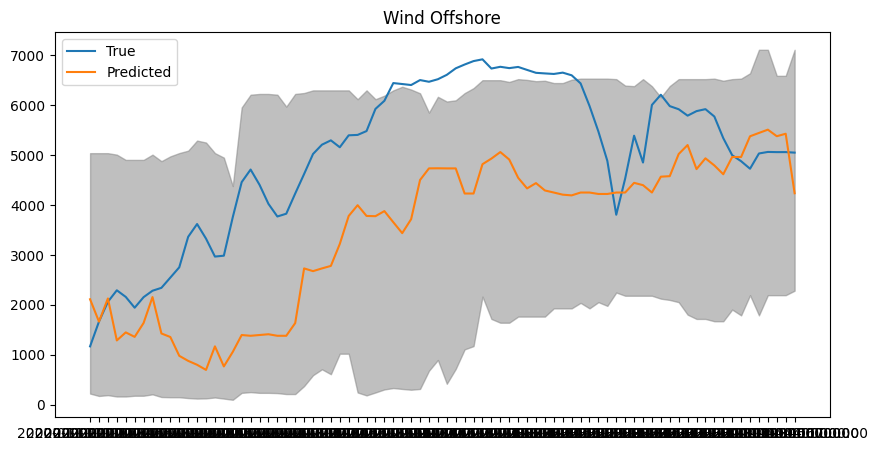

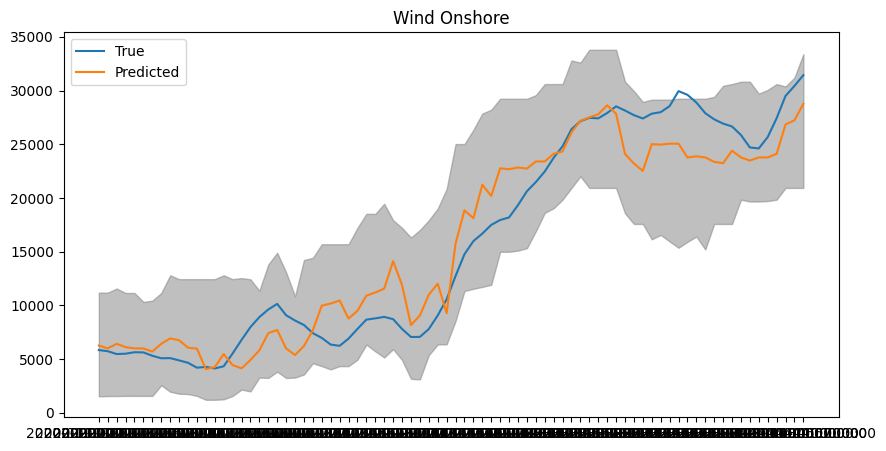

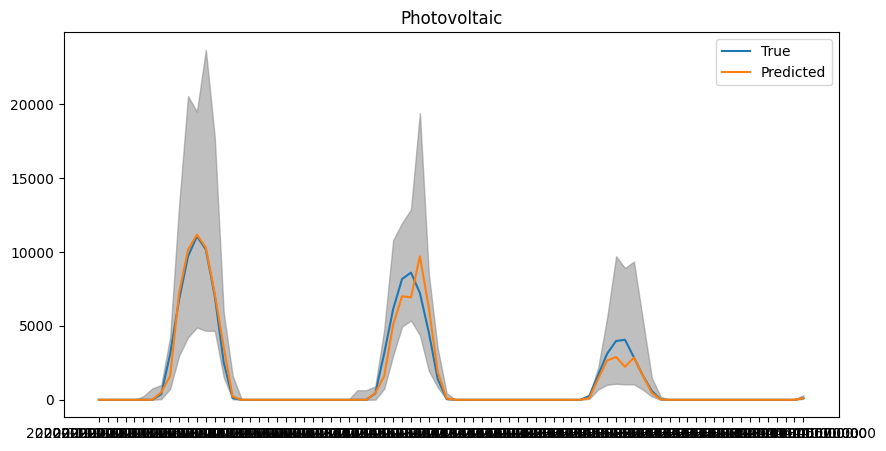

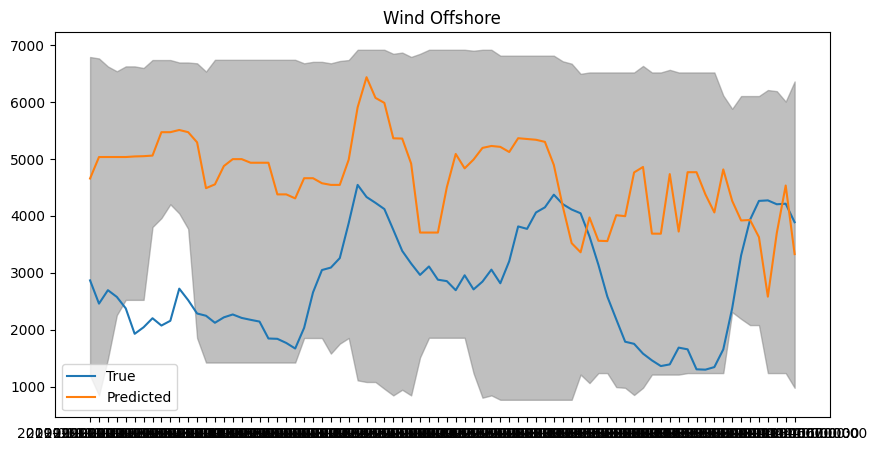

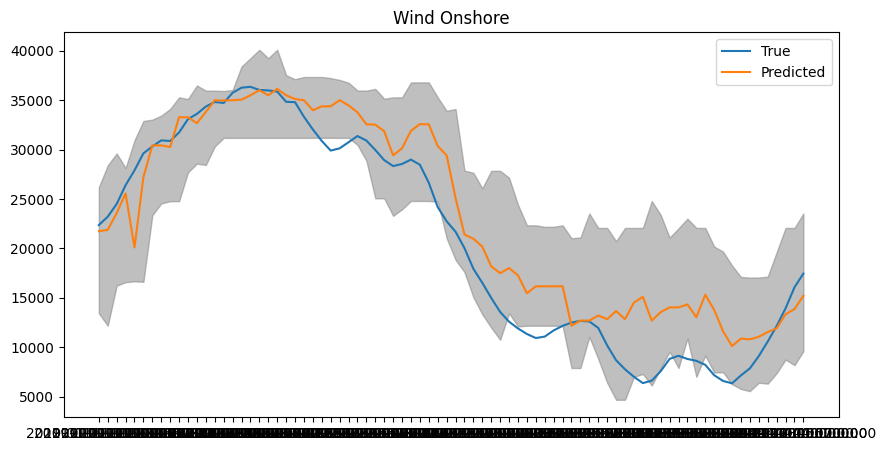

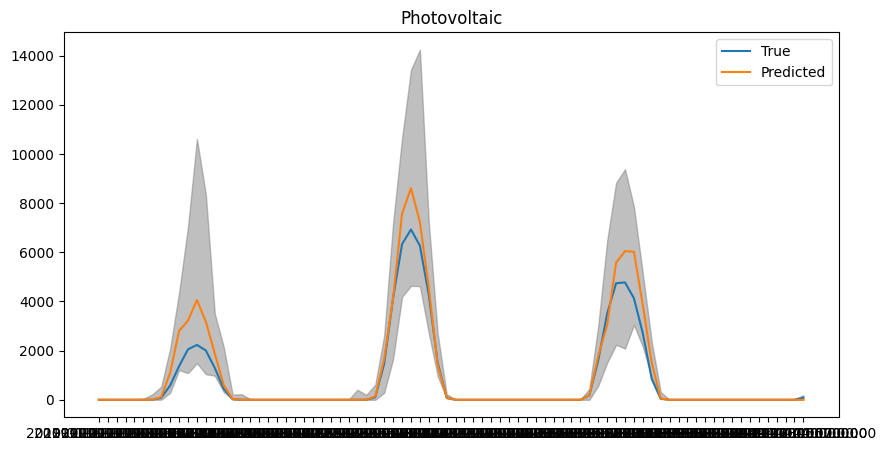

In [99]:

# make crossvalidation where two years are used for training and one year for testing
y_pred_offshore = 0
y_pred_onshore = 0
y_pred_photovoltaic = 0

quantiles = [0.025, 0.5, 0.975]

result_scores = {'offshore': [], 'onshore': [], 'photovoltaic': []}
for train_data, test_data in combinations:
    # predict wind offshore
    X_offshore = train_data.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
    y_offshore = train_data['Wind Offshore [MW] ']
    X_offshore_test = test_data.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
    y_offshore_test = test_data['Wind Offshore [MW] ']

    # predict wind onshore
    X_onshore = train_data.drop(columns=['year','Wind Onshore [MW]', 'Wind Offshore [MW] ', 'Photovoltaic [MW]'])
    y_onshore = train_data['Wind Onshore [MW]']
    X_onshore_test = test_data.drop(columns=['year','Wind Onshore [MW]', 'Wind Offshore [MW] ', 'Photovoltaic [MW]'])
    y_onshore_test = test_data['Wind Onshore [MW]']

    # predict photovoltaic
    X_photovoltaic = train_data.drop(columns=['year','Photovoltaic [MW]', 'Wind Onshore [MW]', 'Wind Offshore [MW] '])
    y_photovoltaic = train_data['Photovoltaic [MW]']
    X_photovoltaic_test = test_data.drop(columns=['year','Photovoltaic [MW]', 'Wind Onshore [MW]', 'Wind Offshore [MW] '])
    y_photovoltaic_test = test_data['Photovoltaic [MW]']

    # train models
    qrf = RandomForestQuantileRegressor()
    qrf.fit(X_offshore, y_offshore);
    y_pred = qrf.predict(X_offshore_test, quantiles=quantiles)

    scores = []
    for q_index, q_value in enumerate(quantiles):
        score = mean_pinball_loss(y_true=y_offshore_test, y_pred=y_pred[:, q_index], alpha=q_value)
        scores.append(score)

    result_scores['offshore'].append(np.mean(scores))


    y_pred_plot = y_pred[0:80]
    y_offshore_test_plot = y_offshore_test[0:80]

    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(y_offshore_test_plot, label='True')
    plt.plot(y_pred_plot[:, 1], label='Predicted')
    plt.fill_between(np.arange(len(y_offshore_test_plot)), y_pred_plot[:, 0], y_pred_plot[:, 2], color='gray', alpha=0.5)
    plt.title('Wind Offshore')
    plt.legend()

    # now onshore
    qrf = RandomForestQuantileRegressor()
    qrf.fit(X_onshore, y_onshore);
    y_pred = qrf.predict(X_onshore_test, quantiles=[0.025, 0.5, 0.975])

    scores = []
    for q_index, q_value in enumerate(quantiles):
        score = mean_pinball_loss(y_true=y_onshore_test, y_pred=y_pred[:, q_index], alpha=q_value)
        scores.append(score)

    result_scores['onshore'].append(np.mean(scores))


    y_pred_plot = y_pred[0:80]
    y_onshore_test_plot = y_onshore_test[0:80]

    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(y_onshore_test_plot, label='True')
    plt.plot(y_pred_plot[:, 1], label='Predicted')
    plt.fill_between(np.arange(len(y_onshore_test_plot)), y_pred_plot[:, 0], y_pred_plot[:, 2], color='gray', alpha=0.5)
    plt.title('Wind Onshore')
    plt.legend()

    # now photovoltaic
    qrf = RandomForestQuantileRegressor()
    qrf.fit(X_photovoltaic, y_photovoltaic);
    y_pred = qrf.predict(X_photovoltaic_test, quantiles=[0.025, 0.5, 0.975])

    scores = []
    for q_index, q_value in enumerate(quantiles):
        score = mean_pinball_loss(y_true=y_photovoltaic_test, y_pred=y_pred[:, q_index], alpha=q_value)
        scores.append(score)

    result_scores['photovoltaic'].append(np.mean(scores))


    y_pred_plot = y_pred[0:80]
    y_photovoltaic_test_plot = y_photovoltaic_test[0:80]
    
    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(y_photovoltaic_test_plot, label='True')
    plt.plot(y_pred_plot[:, 1], label='Predicted')
    plt.fill_between(np.arange(len(y_photovoltaic_test_plot)), y_pred_plot[:, 0], y_pred_plot[:, 2], color='gray', alpha=0.5)
    plt.title('Photovoltaic')
    plt.legend()

# average results
result_scores['offshore'] = np.mean(result_scores['offshore'])
result_scores['onshore'] = np.mean(result_scores['onshore'])
result_scores['photovoltaic'] = np.mean(result_scores['photovoltaic'])
print(result_scores)

In [100]:
# # predict 24 hour in the future
#take training data and shift targets by one hour

training_data_one_day = training_data.copy()

training_data_one_day['Wind Offshore [MW] '] = training_data['Wind Offshore [MW] '].shift(-24)
training_data_one_day['Wind Onshore [MW]'] = training_data['Wind Onshore [MW]'].shift(-24)
training_data_one_day['Photovoltaic [MW]'] = training_data['Photovoltaic [MW]'].shift(-24)

# drop last row
training_data_one_day = training_data_one_day.dropna()

training_data_2019 = training_data_one_day[training_data_one_day['year'] == 2019]
training_data_2020 = training_data_one_day[training_data_one_day['year'] == 2020]
training_data_2021 = training_data_one_day[training_data_one_day['year'] == 2021]




combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without featur

{'offshore': 357.0867831459275, 'onshore': 1390.9649304079173, 'photovoltaic': 256.8596439026243}


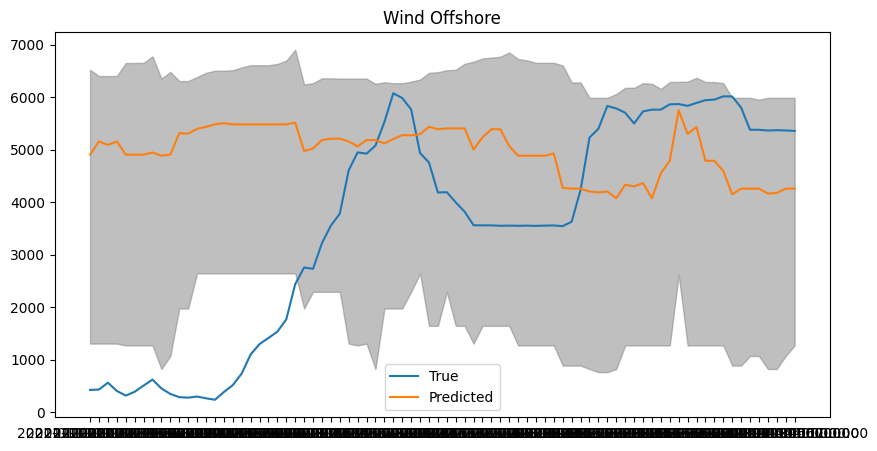

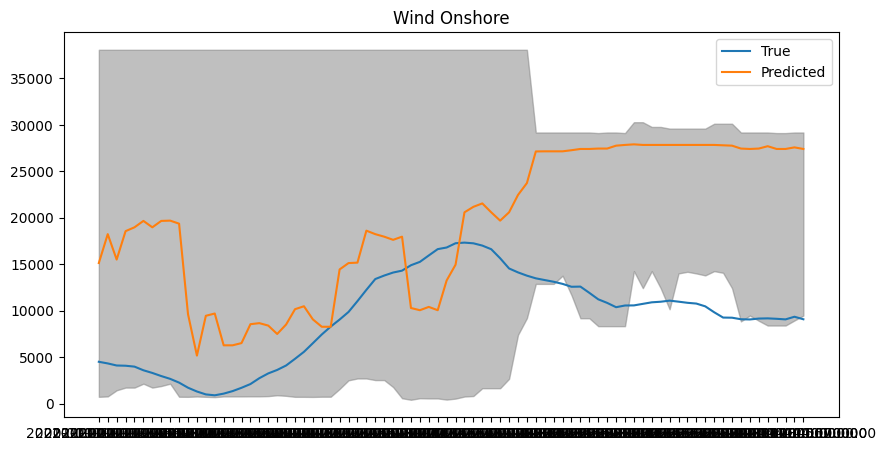

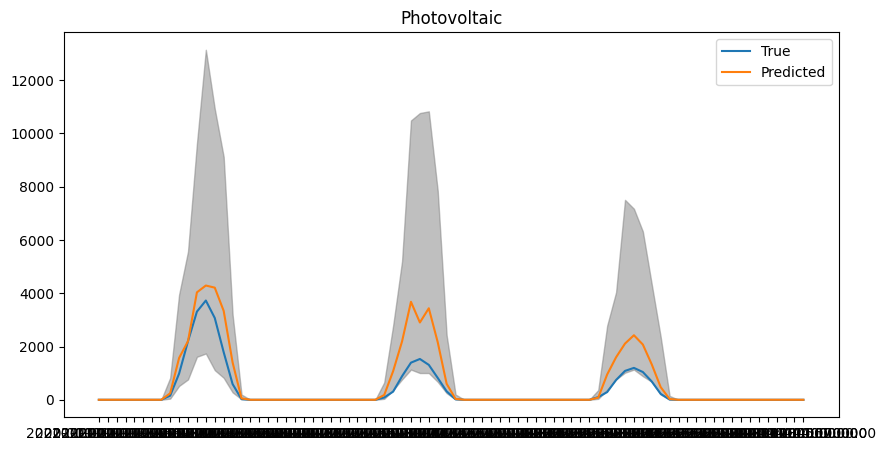

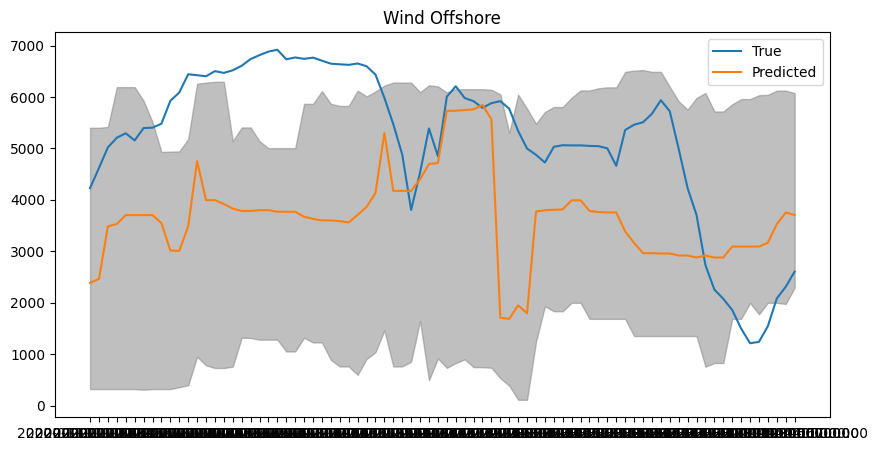

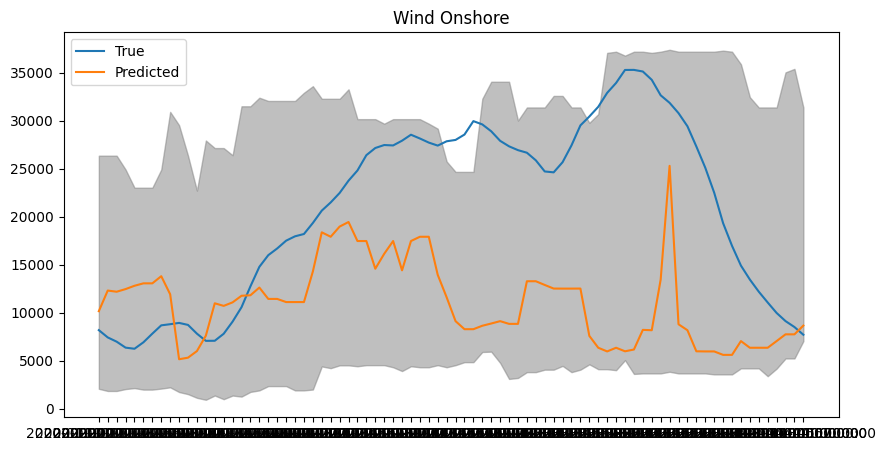

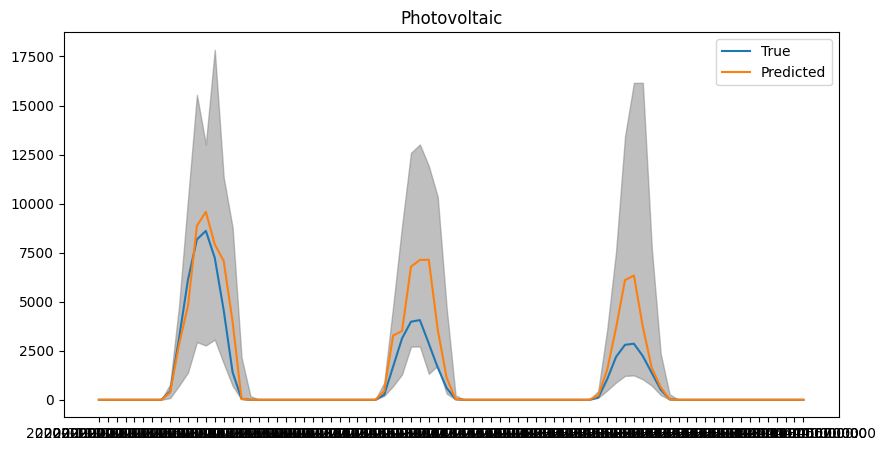

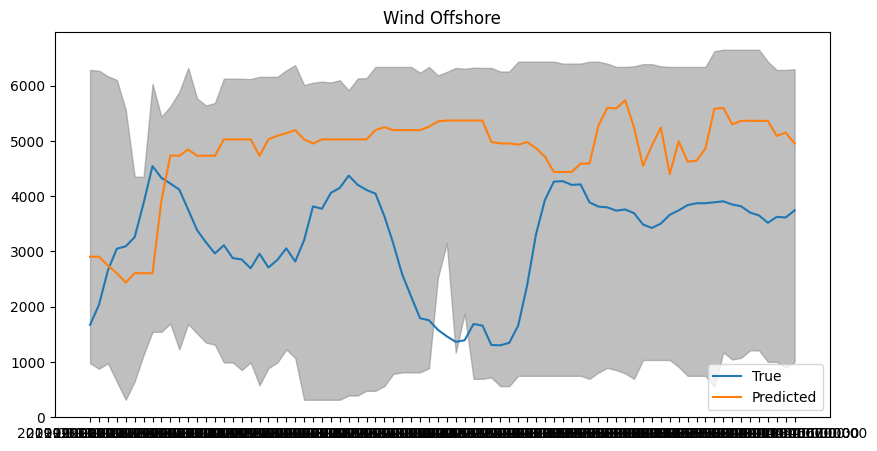

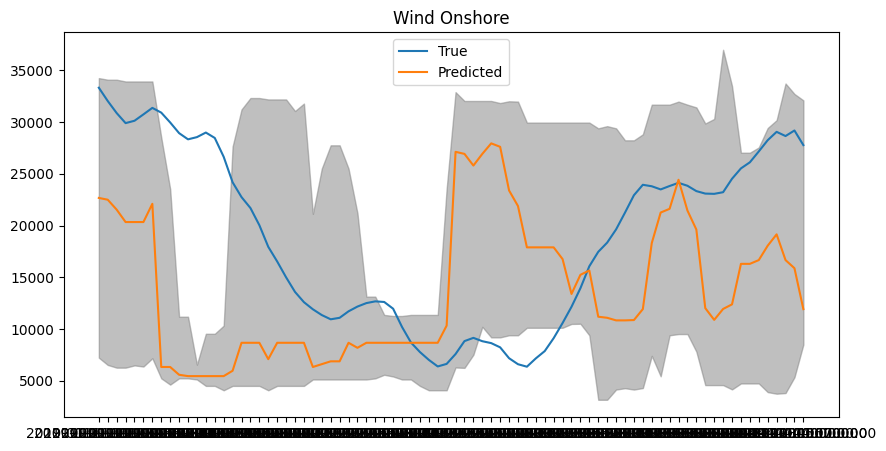

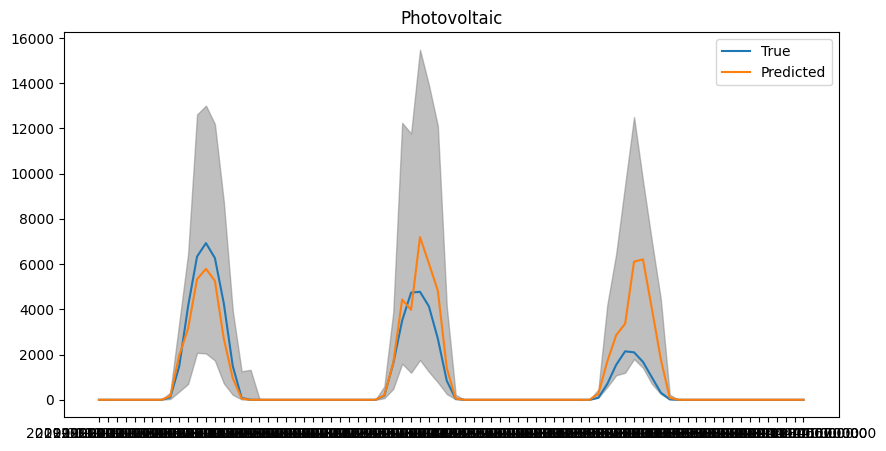

In [101]:

# make crossvalidation where two years are used for training and one year for testing
y_pred_offshore = 0
y_pred_onshore = 0
y_pred_photovoltaic = 0

quantiles = [0.025, 0.5, 0.975]

result_scores = {'offshore': [], 'onshore': [], 'photovoltaic': []}
for train_data, test_data in combinations:
    # predict wind offshore
    X_offshore = train_data.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
    y_offshore = train_data['Wind Offshore [MW] ']
    X_offshore_test = test_data.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
    y_offshore_test = test_data['Wind Offshore [MW] ']

    # predict wind onshore
    X_onshore = train_data.drop(columns=['year','Wind Onshore [MW]', 'Wind Offshore [MW] ', 'Photovoltaic [MW]'])
    y_onshore = train_data['Wind Onshore [MW]']
    X_onshore_test = test_data.drop(columns=['year','Wind Onshore [MW]', 'Wind Offshore [MW] ', 'Photovoltaic [MW]'])
    y_onshore_test = test_data['Wind Onshore [MW]']

    # predict photovoltaic
    X_photovoltaic = train_data.drop(columns=['year','Photovoltaic [MW]', 'Wind Onshore [MW]', 'Wind Offshore [MW] '])
    y_photovoltaic = train_data['Photovoltaic [MW]']
    X_photovoltaic_test = test_data.drop(columns=['year','Photovoltaic [MW]', 'Wind Onshore [MW]', 'Wind Offshore [MW] '])
    y_photovoltaic_test = test_data['Photovoltaic [MW]']

    # train models
    qrf = RandomForestQuantileRegressor()
    qrf.fit(X_offshore, y_offshore);
    y_pred = qrf.predict(X_offshore_test, quantiles=quantiles)

    scores = []
    for q_index, q_value in enumerate(quantiles):
        score = mean_pinball_loss(y_true=y_offshore_test, y_pred=y_pred[:, q_index], alpha=q_value)
        scores.append(score)

    result_scores['offshore'].append(np.mean(scores))


    y_pred_plot = y_pred[0:80]
    y_offshore_test_plot = y_offshore_test[0:80]

    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(y_offshore_test_plot, label='True')
    plt.plot(y_pred_plot[:, 1], label='Predicted')
    plt.fill_between(np.arange(len(y_offshore_test_plot)), y_pred_plot[:, 0], y_pred_plot[:, 2], color='gray', alpha=0.5)
    plt.title('Wind Offshore')
    plt.legend()

    # now onshore
    qrf = RandomForestQuantileRegressor()
    qrf.fit(X_onshore, y_onshore);
    y_pred = qrf.predict(X_onshore_test, quantiles=[0.025, 0.5, 0.975])

    scores = []
    for q_index, q_value in enumerate(quantiles):
        score = mean_pinball_loss(y_true=y_onshore_test, y_pred=y_pred[:, q_index], alpha=q_value)
        scores.append(score)

    result_scores['onshore'].append(np.mean(scores))


    y_pred_plot = y_pred[0:80]
    y_onshore_test_plot = y_onshore_test[0:80]

    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(y_onshore_test_plot, label='True')
    plt.plot(y_pred_plot[:, 1], label='Predicted')
    plt.fill_between(np.arange(len(y_onshore_test_plot)), y_pred_plot[:, 0], y_pred_plot[:, 2], color='gray', alpha=0.5)
    plt.title('Wind Onshore')
    plt.legend()

    # now photovoltaic
    qrf = RandomForestQuantileRegressor()
    qrf.fit(X_photovoltaic, y_photovoltaic);
    y_pred = qrf.predict(X_photovoltaic_test, quantiles=[0.025, 0.5, 0.975])

    scores = []
    for q_index, q_value in enumerate(quantiles):
        score = mean_pinball_loss(y_true=y_photovoltaic_test, y_pred=y_pred[:, q_index], alpha=q_value)
        scores.append(score)

    result_scores['photovoltaic'].append(np.mean(scores))


    y_pred_plot = y_pred[0:80]
    y_photovoltaic_test_plot = y_photovoltaic_test[0:80]
    
    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(y_photovoltaic_test_plot, label='True')
    plt.plot(y_pred_plot[:, 1], label='Predicted')
    plt.fill_between(np.arange(len(y_photovoltaic_test_plot)), y_pred_plot[:, 0], y_pred_plot[:, 2], color='gray', alpha=0.5)
    plt.title('Photovoltaic')
    plt.legend()

# average results
result_scores['offshore'] = np.mean(result_scores['offshore'])
result_scores['onshore'] = np.mean(result_scores['onshore'])
result_scores['photovoltaic'] = np.mean(result_scores['photovoltaic'])
print(result_scores)
# old [0.3604837916240635, 0.7610238180502263, 0.9064585509229429, 0.351400272413799, 0.8119779727328822, 0.9286052478785203, 0.06681603279290993, 0.7939381342043816, 0.922916477166824]

In [102]:
# same but now use north german data for offshore

In [103]:
# predict one hour in the future
#take training data and shift targets by one hour
training_data_one_hr = training_data_north.copy()

training_data_one_hr['Wind Offshore [MW] '] = training_data_north['Wind Offshore [MW] '].shift(-1)
training_data_one_hr['Wind Onshore [MW]'] = training_data_north['Wind Onshore [MW]'].shift(-1)
training_data_one_hr['Photovoltaic [MW]'] = training_data_north['Photovoltaic [MW]'].shift(-1)

# drop last row
training_data_one_hr = training_data_one_hr.dropna()

training_data_2019 = training_data_one_hr[training_data_one_hr['year'] == 2019]
training_data_2020 = training_data_one_hr[training_data_one_hr['year'] == 2020]
training_data_2021 = training_data_one_hr[training_data_one_hr['year'] == 2021]




combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


218.31488206368695


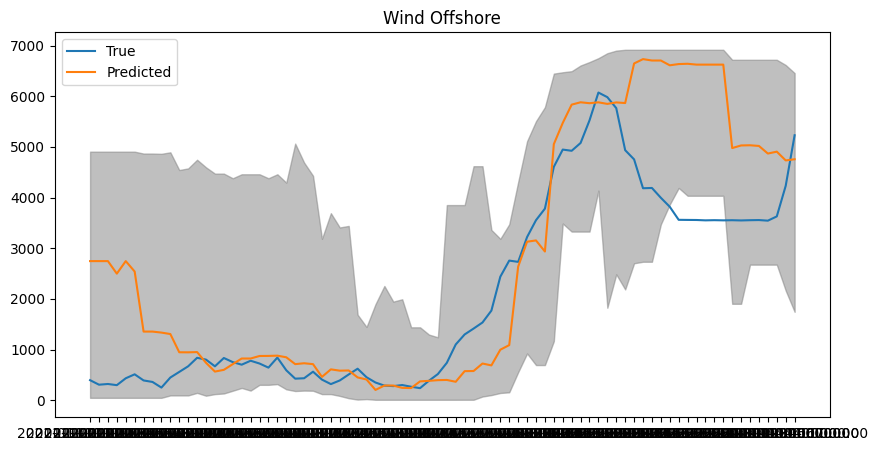

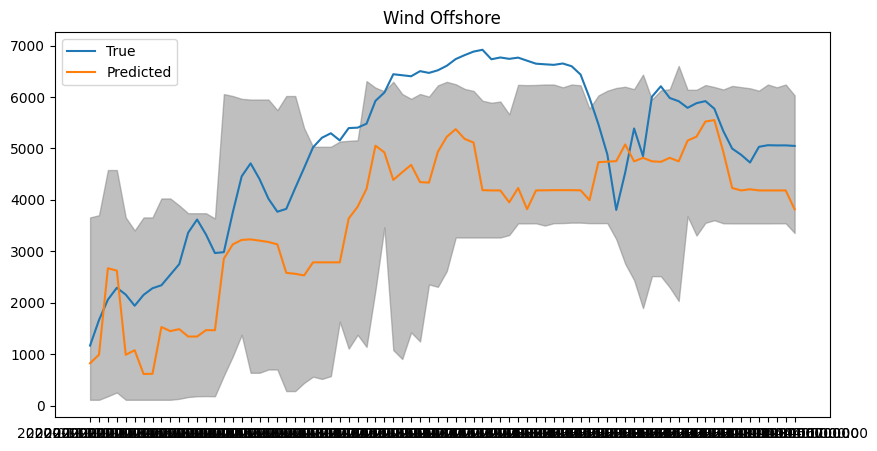

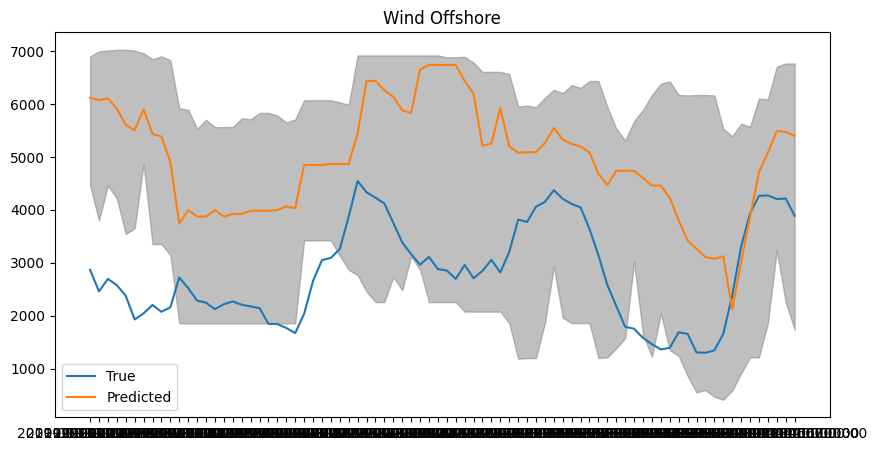

In [104]:

# make crossvalidation where two years are used for training and one year for testing
y_pred_offshore = 0
quantiles = [0.025, 0.5, 0.975]

result_scores = {'offshore': []}
for train_data, test_data in combinations:
    # predict wind offshore
    X_offshore = train_data.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
    y_offshore = train_data['Wind Offshore [MW] ']
    X_offshore_test = test_data.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
    y_offshore_test = test_data['Wind Offshore [MW] ']

    # train models
    qrf = RandomForestQuantileRegressor()
    qrf.fit(X_offshore, y_offshore);
    y_pred = qrf.predict(X_offshore_test, quantiles=quantiles)

    scores = []
    for q_index, q_value in enumerate(quantiles):
        score = mean_pinball_loss(y_true=y_offshore_test, y_pred=y_pred[:, q_index], alpha=q_value)
        scores.append(score)

    result_scores['offshore'].append(np.mean(scores))


    y_pred_plot = y_pred[0:80]
    y_offshore_test_plot = y_offshore_test[0:80]

    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(y_offshore_test_plot, label='True')
    plt.plot(y_pred_plot[:, 1], label='Predicted')
    plt.fill_between(np.arange(len(y_offshore_test_plot)), y_pred_plot[:, 0], y_pred_plot[:, 2], color='gray', alpha=0.5)
    plt.title('Wind Offshore')
    plt.legend()

result_scores['offshore'] = np.mean(result_scores['offshore'])
print(result_scores['offshore'])

In [105]:
# # predict 24 hour in the future
#take training data and shift targets by one hour

training_data_one_day = training_data_north.copy()

training_data_one_day['Wind Offshore [MW] '] = training_data_north['Wind Offshore [MW] '].shift(-24)
training_data_one_day['Wind Onshore [MW]'] = training_data_north['Wind Onshore [MW]'].shift(-24)
training_data_one_day['Photovoltaic [MW]'] = training_data_north['Photovoltaic [MW]'].shift(-24)

# drop last row
training_data_one_day = training_data_one_day.dropna()

training_data_2019 = training_data_one_day[training_data_one_day['year'] == 2019]
training_data_2020 = training_data_one_day[training_data_one_day['year'] == 2020]
training_data_2021 = training_data_one_day[training_data_one_day['year'] == 2021]




combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


360.88416465530935


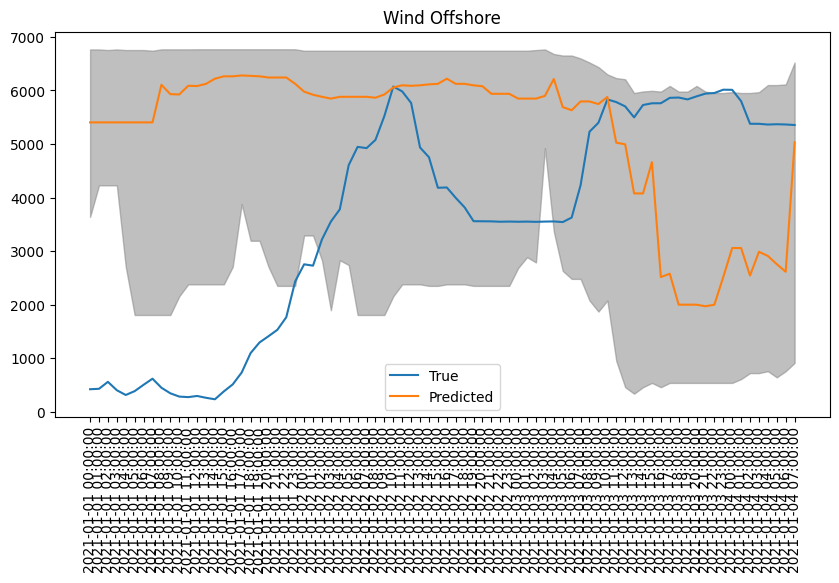

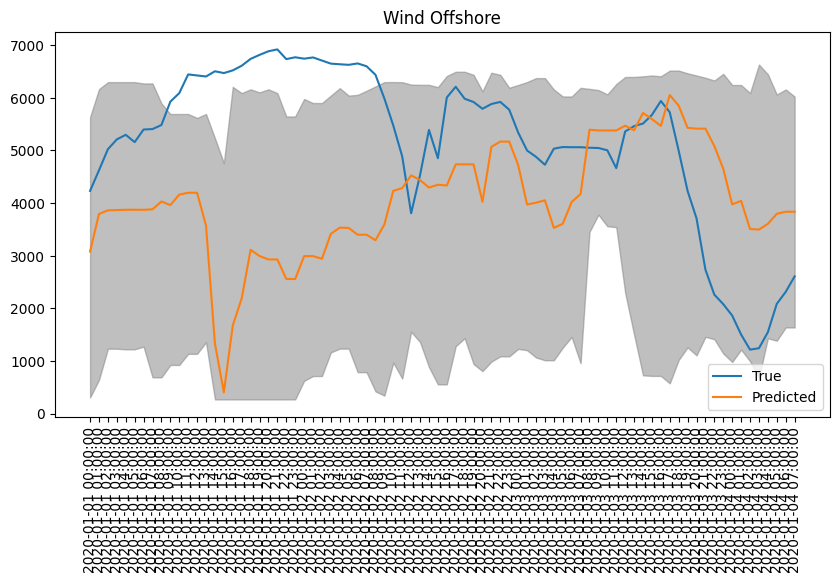

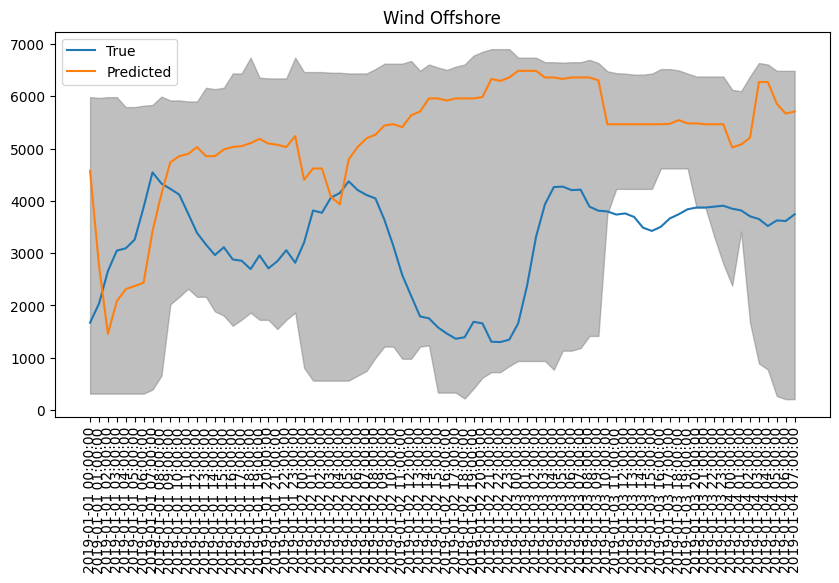

In [106]:

# make crossvalidation where two years are used for training and one year for testing
y_pred_offshore = 0
quantiles = [0.025, 0.5, 0.975]

result_scores = {'offshore': []}
for train_data, test_data in combinations:
    # predict wind offshore
    X_offshore = train_data.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
    y_offshore = train_data['Wind Offshore [MW] ']
    X_offshore_test = test_data.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
    y_offshore_test = test_data['Wind Offshore [MW] ']

    # train models
    qrf = RandomForestQuantileRegressor()
    qrf.fit(X_offshore, y_offshore);
    y_pred = qrf.predict(X_offshore_test, quantiles=quantiles)

    scores = []
    for q_index, q_value in enumerate(quantiles):
        score = mean_pinball_loss(y_true=y_offshore_test, y_pred=y_pred[:, q_index], alpha=q_value)
        scores.append(score)

    result_scores['offshore'].append(np.mean(scores))


    y_pred_plot = y_pred[0:80]
    y_offshore_test_plot = y_offshore_test[0:80]

    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(y_offshore_test_plot, label='True')
    plt.plot(y_pred_plot[:, 1], label='Predicted')
    # tilt x axis labels
    plt.xticks(rotation=90)
    plt.fill_between(np.arange(len(y_offshore_test_plot)), y_pred_plot[:, 0], y_pred_plot[:, 2], color='gray', alpha=0.5)
    plt.title('Wind Offshore')
    plt.legend()

# average results
result_scores['offshore'] = np.mean(result_scores['offshore'])
print(result_scores['offshore'])